In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.2  Device: cuda


In [3]:
BATCH_SIZE = 64
EPOCHS = 10
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

In [4]:
# ssl 인증서 오류 해결
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                  transforms.Resize(256),# (300,300)로 resize
                                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 밝기 : 0.2, 대비 : 0.2, 채도 : 0.2, 색조 : 0.2
                                  transforms.TenCrop(224), # 네 모서리와 중앙 자르기
                                  transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])), # 한 줄로 나열
                                  transforms.RandomHorizontalFlip(), # 수평반전 50
                                  ]))

# transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [15]:
''' 4. 데이터 확인하기'''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 5, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


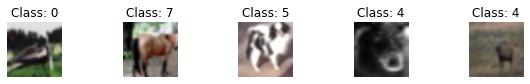

In [20]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i][i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

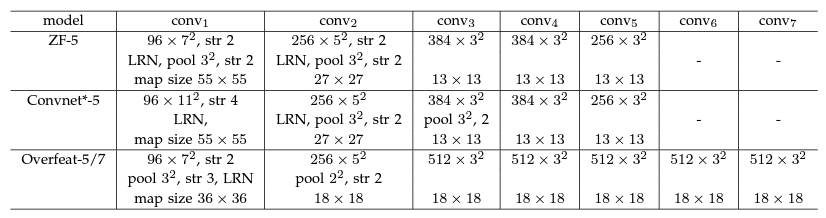

In [21]:
''' 6. (SPP) 모델 설계하기 '''

import math
def spatial_pyramid_pool(previous_conv, num_sample, previous_conv_size, out_pool_size):
    '''
    previous_conv: a tensor vector of previous convolution layer
    num_sample: an int number of image in the batch
    previous_conv_size: an int vector [height, width] of the matrix features size of previous convolution layer
    out_pool_size: a int vector of expected output size of max pooling layer
    
    returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
    '''    
    # print(previous_conv.size())
    for i in range(len(out_pool_size)):
        # print(previous_conv_size)
        h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i])) # 올림
        w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
        h_wid_1 = int(math.floor(previous_conv_size[0] / out_pool_size[i])) # 내림
        w_wid_1 = int(math.floor(previous_conv_size[1] / out_pool_size[i]))
        maxpool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid_1, w_wid_1))
        x = maxpool(previous_conv)
        if(i == 0):
            spp = x.view(num_sample,-1)
            # print("spp size:",spp.size())
        else:
            # print("size:",spp.size())
            spp = torch.cat((spp,x.view(num_sample,-1)), 1)
    return spp

In [29]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
class SPP_NET(nn.Module):
    '''
    A SPP model which adds spp layer so that we can input multi-size tensor
    '''
    def __init__(self, output_num = [4,2,1], input_nc = 3, ndf=96,  gpu_ids=[]): # bin = 21
        super(SPP_NET, self).__init__()
        self.gpu_ids = gpu_ids
        self.output_num = output_num
        
        self.conv1 = nn.Conv2d(input_nc, ndf, kernel_size = 11, stride= 4, padding=2, bias=False) #(55, 55, 96)
        self.LRN1 = nn.LocalResponseNorm(size=2) # 임의로 size = 2로 설정
        

        self.conv2 = nn.Conv2d(ndf, 256, kernel_size = 5, stride = 2, padding = 29, bias=False) #(55, 55, 256)
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2) #(27, 27, 256)
        self.LRN2 = nn.LocalResponseNorm(size=2)

        self.conv3 = nn.Conv2d(256, ndf * 4, kernel_size = 3, stride = 2, padding = 14, bias=False) #(27, 27, 384)
        self.pool3 = nn.MaxPool2d(kernel_size = 3, stride = 2) #(13, 13, 384)

        self.conv4 = nn.Conv2d(ndf * 4, ndf * 4, kernel_size = 3, stride=1, padding=1, bias=False) #(13, 13, 384)
        
        self.conv5 = nn.Conv2d(ndf * 4, 256, kernel_size = 3, stride=1, padding=1, bias=False) #(13, 13, 256)

        self.fc1 = nn.Linear(5376,320)
        self.fc2 = nn.Linear(320,10)


        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.conv1(x)
        x = F.leaky_relu(x) #leaky_relu, 활성화 함수
        x = self.LRN1(x)

        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.pool2(x)
        x = self.LRN2(x)
        
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x= self.pool3(x)

        x = self.conv4(x)
        x = F.leaky_relu(x)

        x = self.conv5(x)
        spp = spatial_pyramid_pool(x,320,[13, 13],self.output_num)

        # spp = spatial_pyramid_pool(x, 4096,[13,13],self.output_num)
        # print(spp.size())  pooling 대신 spp_pooling
        fc1 = self.fc1(spp)
        x = self.dropout(fc1)

        fc2 = self.fc2(x)
        x = self.dropout(fc2)

        output = nn.functional.log_softmax(x, dim = 1)
        return output

In [30]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = SPP_NET().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

SPP_NET(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
  (LRN1): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(29, 29), bias=False)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (LRN2): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(2, 2), padding=(14, 14), bias=False)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Linear(in_features=5376, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [31]:
''' 8. SPP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        bs, ncrops, c, h, w = image.size()
        result = model(image.view(-1, c, h, w)) # fuse batch size and ncrops
        output = result.view(bs, ncrops, -1).mean(1) # avg over crops
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [32]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            bs, ncrops, c, h, w = image.size()
            result = model(image.view(-1, c, h, w)) # fuse batch size and ncrops
            output = result.view(bs, ncrops, -1).mean(1) # avg over crops
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [33]:
import gc
gc.collect()

26

In [34]:
''' 10. SPP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

RuntimeError: CUDA out of memory. Tried to allocate 356.00 MiB (GPU 0; 4.00 GiB total capacity; 2.36 GiB already allocated; 43.90 MiB free; 2.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF